### Motivating Recurrent Neural Networks
Picking up the discussion from where we left off, we proposed a model over 2 variables $x_1, x_2$, learning a distribution $p(x_1, x_2)$ as $p(x_1) \cdot p(x_2 ~|~ x_1)$, where 
- $p(x_1)$ is estimated using a histogram
- $p(x_2 ~|~ x_1)$ is estimated using a MLP

The conclusion being that such a model is bad because
- there is one function approximator per conditional
- no information is shared amoungst different conditionals

The solution to both problems being share parameters between a single function approximator

### RNN Review

What is an RNN?
```python
def rnn_step(self, input, hidden):
    # if we simply had
    # hidden = torch.tanh(input @ self.Wxh + self.bh)
    # it would just be a multi layer perceptron

    # by adding hidden @ self.Whh we using the context of the previous
    # hidden state
    hidden = input @ self.Wxh +  hidden @ self.Whh + self.bh
    output = hidden @ self.Why + self.by

    output = self.softmax(output)

    return output, hidden
```
The comment really covers it, an RNN distinguishes itself from a MLP in that with each step we are not only updating the weights of previous layers, but carrying forward the hidden state from past iterations. To see in more detail how the LSTM improves on the existing RNN model, see the nlp section.

### Imports

In [1]:
# Visualization
import matplotlib.pyplot as plt

# data processing
import numpy as np
from tqdm import tqdm

# Torch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

# Torchvision Imports
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [2]:
# GPU acceleration
gpu = torch.device("cuda:0")

### Dataset

In [3]:
MNIST_SIZE = 28

# important: 
# must transfor all images to binary, else the loss function is all wrong
trans = transforms.Compose([
                            transforms.Grayscale(), 
                            transforms.Resize((MNIST_SIZE, MNIST_SIZE)), 
                            transforms.ToTensor(),
                            lambda x: x>0,
                            lambda x: x.float(),
])
mnist_dataset = datasets.MNIST(root='./sample_data', train=True, download=True, transform=trans)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, shuffle=True, batch_size=64)

### Architecture Overview
Generating MNIST images pixel by pixel with an lstm, the idea here being lstm's are good because they share the parameters from all previous generated pixels

In [4]:
class RNN_Example(nn.Module):
    
    def __init__(self, device, input_shape=(1, 28, 28), hidden_size=256):
        super().__init__()
        self.device = device
        self.input_channels = input_shape[0] + 2 if append_loc else input_shape[0]
        self.hidden_size = hidden_size
        self.input_shape = input_shape
        self.canvas_size = input_shape[1] * input_shape[2]

        self.lstm = nn.LSTM(self.input_channels, self.hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, input_shape[0])

    def loss(self, x_inp):
        batch_size = x.shape[0]

        # reshape into 784 dim vector
        x_inp = x_inp.view(batch_size, self.canvas_size, self.input_channels)
        
        # remove last pixel, prepend 0 as first pixel
        x_inp = torch.cat((torch.zeros(batch_size, 1, self.input_channels).to(self.device), x_inp[:, :-1]), dim=1)

        h0 = torch.zeros(1, x_inp.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(1, x_inp.size(0), self.hidden_size).to(self.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x_inp, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out).squeeze(-1) # b x 784

        return F.binary_cross_entropy_with_logits(out, x.view(batch_size, -1))


    def sample(self, n):
        """
        kinda an important thing to note here:
            each sample can be generated in parallel, but generating a single
            scales linearly with the number of pixels in the image.
            
            eg. a image with 100 pixels should generate 20 times faster than
            an image with 2,000 pixels
        """
        with torch.no_grad():
            # vector of zeros (note that this repsents the initial pixel)
            samples = torch.zeros(n, 1, self.input_channels).to(self.device)
            
            # vector of hidden states
            h = torch.zeros(1, n, self.hidden_size).to(self.device)
            
            # vector of content states
            c = torch.zeros(1, n, self.hidden_size).to(self.device)
            
            # generate pixel by pixel
            for i in range(self.canvas_size):
                x_inp = samples[:, [i]]
                out, (h, c) = self.lstm(x_inp, (h, c))
                out = self.fc(out[:, 0, :])
                prob = torch.sigmoid(out)
                sample_pixel = torch.bernoulli(prob).unsqueeze(-1) # n x 1 x 1
                samples = torch.cat((samples, sample_pixel), dim=1)


            samples = samples[:, 1:].squeeze(-1) # n x 784
            samples = samples.view(n, *self.input_shape)
            return samples.cpu()

### Training

In [5]:
def train(train_loader, d, num_epochs=20):
    model = RNN_Example(gpu)
    model = model.to(gpu)
    
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=.9)
    train_loss = []
    
    for epoch in tqdm(range(num_epochs), desc='Training model'):  # loop over the dataset multiple times
        for i, data in enumerate(train_loader):
            images = data[0].to(gpu)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            loss = model.loss(images)
            train_loss.append(loss.mean().cpu().item())
            loss.backward()
            optimizer.step()
        
        if epoch in [0, 5, 10, 15]:
            samples = model.sample(64)
            save_sample(samples, '{}_epoch.jpg'.format(epoch))
            
    return model, train_loss

def plot_sample(samples, title):
    grid_img = make_grid(samples, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(title)
    
def save_sample(samples, title):
    grid_img = make_grid(samples, nrow=8)
    plt.imsave(title, grid_img.permute(1, 2, 0).numpy())
    

In [6]:
rnn_mnist_generator, train_loss = train(mnist_loader, gpu)

Training model: 100%|██████████| 20/20 [13:28<00:00, 40.43s/it]


### Visualization

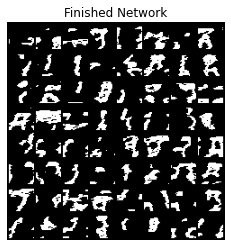

In [7]:
samples = rnn_mnist_generator.sample(64)
plot_sample(samples, 'Finished Network')

Text(0.5, 1.0, 'Train Loss')

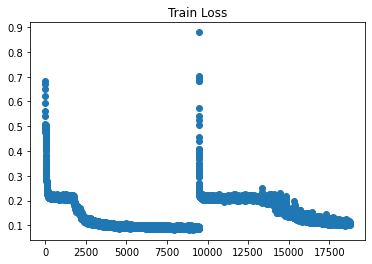

In [8]:
plt.scatter(range(len(train_loss)), train_loss)
plt.title('Train Loss')